In [ ]:
!pip install pefile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pefile
import struct
import math


In [ ]:
def extract_features(exe_file_path):
    # Initialize an empty dictionary to store the extracted features
    features = {}

    # Open the PE file using pefile
    pe = pefile.PE(exe_file_path)

    # Extract characteristics
    features['Characteristics'] = pe.FILE_HEADER.Characteristics

    # Extract linker version
    features['MajorLinkerVersion'] = pe.OPTIONAL_HEADER.MajorLinkerVersion
    features['MinorLinkerVersion'] = pe.OPTIONAL_HEADER.MinorLinkerVersion

    # Extract sizes of code, initialized data, uninitialized data
    features['SizeOfCode'] = pe.OPTIONAL_HEADER.SizeOfCode
    features['SizeOfInitializedData'] = pe.OPTIONAL_HEADER.SizeOfInitializedData
    features['SizeOfUninitializedData'] = pe.OPTIONAL_HEADER.SizeOfUninitializedData

    # Extract resource information
    resources = pe.DIRECTORY_ENTRY_RESOURCE
    features['ResourcesNb'] = len(resources.entries)
    if features['ResourcesNb'] > 0:
        entropy_values = []
        sizes = []
        for entry in resources.entries:
            if entry.directory:
                for e in entry.directory.entries:
                    if hasattr(e, 'data'):
                        entropy_values.append(calculate_entropy(e.data))
                        sizes.append(len(e.data))
        if entropy_values:
            features['ResourcesMeanEntropy'] = sum(entropy_values) / len(entropy_values)
            features['ResourcesMinEntropy'] = min(entropy_values)
            features['ResourcesMaxEntropy'] = max(entropy_values)
        if sizes:
            features['ResourcesMeanSize'] = sum(sizes) / len(sizes)
            features['ResourcesMinSize'] = min(sizes)
            features['ResourcesMaxSize'] = max(sizes)

    # Extract load configuration size
    features['LoadConfigurationSize'] = pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY['IMAGE_DIRECTORY_ENTRY_LOAD_CONFIG']].Size

    # Extract version information size
    #version_info = pe.VS_FIXEDFILEINFO
    #if version_info:
        # Since version_info is a list, you may need to access its elements
        #for info in version_info:
            # Accessing the version information size
            #features['VersionInformationSize'] = info.dwFileFlags

    return features

# Example usage
exe_file_path = '/content/drive/MyDrive/transmac-15.2-installer_R-mJEN1.exe'
extracted_features = extract_features(exe_file_path)
print(extracted_features)
extracted_features

{'Characteristics': 33167, 'MajorLinkerVersion': 2, 'MinorLinkerVersion': 25, 'SizeOfCode': 741888, 'SizeOfInitializedData': 89600, 'SizeOfUninitializedData': 0, 'ResourcesNb': 6, 'LoadConfigurationSize': 0}


{'Characteristics': 33167,
 'MajorLinkerVersion': 2,
 'MinorLinkerVersion': 25,
 'SizeOfCode': 741888,
 'SizeOfInitializedData': 89600,
 'SizeOfUninitializedData': 0,
 'ResourcesNb': 6,
 'LoadConfigurationSize': 0}

In [ ]:
def calculate_entropy(data):
    # Calculate entropy of data
    if not data:
        return 0.0
    entropy = 0
    for x in range(1000):
        p_x = float(data.count(x)) / len(data)
        if p_x > 0:
            entropy += - p_x * math.log(p_x, 2)
    return entropy

def extract_resource_entropy(exe_file_path):
    # Open the PE file using pefile
    pe = pefile.PE(exe_file_path)

    # Extract resource information
    resources = pe.DIRECTORY_ENTRY_RESOURCE
    if not resources:
        return None, None, None  # No resources found

    entropy_values = []
    for entry in resources.entries:
        if entry.directory:
            for e in entry.directory.entries:
                if hasattr(e, 'data'):
                    entropy_values.append(calculate_entropy(e.data))

    if not entropy_values:
        return None, None, None  # No entropy values found

    mean_entropy = sum(entropy_values) / len(entropy_values)
    min_entropy = min(entropy_values)
    max_entropy = max(entropy_values)

    return mean_entropy, min_entropy, max_entropy

# Example usage
exe_file_path = '/content/drive/MyDrive/transmac-15.2-installer_R-mJEN1.exe'
mean_entropy, min_entropy, max_entropy = extract_resource_entropy(exe_file_path)
print("Mean Entropy:", mean_entropy)
print("Min Entropy:", min_entropy)
print("Max Entropy:", max_entropy)

Mean Entropy: None
Min Entropy: None
Max Entropy: None


In [ ]:
#import pefile

# Open the PE file using pefile
pe = pefile.PE('/content/drive/MyDrive/transmac-15.2-installer_R-mJEN1.exe')

# Extract version information
version_info = pe.VS_FIXEDFILEINFO
if version_info:
    for info in version_info:
        print(dir(info))  # Print all attributes of the info object


['FileDateLS', 'FileDateMS', 'FileFlags', 'FileFlagsMask', 'FileOS', 'FileSubtype', 'FileType', 'FileVersionLS', 'FileVersionMS', 'ProductVersionLS', 'ProductVersionMS', 'Signature', 'StrucVersion', '__all_zeroes__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__field_offsets__', '__file_offset__', '__format__', '__format_length__', '__format_str__', '__ge__', '__get_format__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__keys__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pack__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__unpack__', '__unpacked_data_elms__', '__weakref__', 'all_zeroes', 'dump', 'dump_dict', 'get_field_absolute_offset', 'get_field_relative_offset', 'get_file_offset', 'name', 'set_file_offset', 'sizeof']


In [ ]:
import math

def calculate_entropy(file_path, block_size=65536):
    # Initialize a dictionary to count the occurrences of each byte
    byte_count = {}

    # Initialize the total byte count
    total_bytes = 0

    # Open the file in binary mode
    with open(file_path, 'rb') as file:
        while True:
            # Read a block of bytes from the file
            block = file.read(block_size)
            if not block:
                break  # Reached end of file

            # Update the total byte count
            total_bytes += len(block)

            # Count the occurrences of each byte in the block
            for byte in block:
                byte_count[byte] = byte_count.get(byte, 0) + 1

    # Calculate the entropy
    entropy = 0
    for count in byte_count.values():
        probability = count / total_bytes
        entropy -= probability * math.log2(probability)

    return entropy

# Example usage
exe_file_path = '/content/drive/MyDrive/transmac-15.2-installer_R-mJEN1.exe'
entropy = calculate_entropy(exe_file_path)
print("Entropy:", entropy)


Entropy: 7.462433609731889


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Ransomware final.csv")

In [ ]:
data.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.00000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.00000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.27273,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.00000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.50000,849,1300,72,18,1


In [ ]:
data.columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

In [ ]:
extractable = pd.DataFrame(data[['Characteristics','MajorLinkerVersion',
 'MinorLinkerVersion',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'ResourcesNb',
 'LoadConfigurationSize']])

In [ ]:
extractable.head()

,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,ResourcesNb,LoadConfigurationSize
0,258,9,0,361984,115712,0,4,0
1,3330,9,0,130560,19968,0,2,72
2,3330,9,0,517120,621568,0,11,72
3,258,9,0,585728,369152,0,10,72
4,258,9,0,294912,247296,0,2,72


In [ ]:
extractable.isnull().sum()

Characteristics            0
MajorLinkerVersion         0
MinorLinkerVersion         0
SizeOfCode                 0
SizeOfInitializedData      0
SizeOfUninitializedData    0
ResourcesNb                0
LoadConfigurationSize      0
dtype: int64

In [ ]:
entropy_data = pd.DataFrame(data[['ResourcesMeanEntropy','ResourcesMinEntropy', 'ResourcesMaxEntropy']])

In [ ]:
entropy_data.isnull().sum()

ResourcesMeanEntropy    0
ResourcesMinEntropy     0
ResourcesMaxEntropy     0
dtype: int64

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'data' is your original DataFrame containing the columns 'ResourcesMeanEntropy', 'ResourcesMinEntropy', and 'ResourcesMaxEntropy'
entropy_data = pd.DataFrame(data[['ResourcesMeanEntropy','ResourcesMinEntropy', 'ResourcesMaxEntropy']])

# Calculate the entropy for each row
def calculate_entropy(row):
    min_entropy = row['ResourcesMinEntropy']
    max_entropy = row['ResourcesMaxEntropy']
    mean_entropy = row['ResourcesMeanEntropy']

    # Normalize the entropy values to probabilities
    p_min = min_entropy / max_entropy
    p_max = 1.0
    p_mean = mean_entropy / max_entropy

    # Calculate the entropy using the formula
    entropy = -(p_min * np.log2(p_min) + p_mean * np.log2(p_mean) + p_max * np.log2(p_max))*10

    return entropy

# Apply the function to each row to calculate entropy and add it as a new column
entropy_data['Entropy'] = entropy_data.apply(calculate_entropy, axis=1)


<ipython-input-17-b07d1d3fe05b>:19: RuntimeWarning: divide by zero encountered in log2
  entropy = -(p_min * np.log2(p_min) + p_mean * np.log2(p_mean) + p_max * np.log2(p_max))*10
<ipython-input-17-b07d1d3fe05b>:19: RuntimeWarning: invalid value encountered in scalar multiply
  entropy = -(p_min * np.log2(p_min) + p_mean * np.log2(p_mean) + p_max * np.log2(p_max))*10
<ipython-input-17-b07d1d3fe05b>:14: RuntimeWarning: invalid value encountered in scalar divide
  p_min = min_entropy / max_entropy
<ipython-input-17-b07d1d3fe05b>:16: RuntimeWarning: invalid value encountered in scalar divide
  p_mean = mean_entropy / max_entropy


In [ ]:
entropy_data

,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,Entropy
0,3.262823,2.568844,3.537939,4.430058
1,4.250461,3.420744,5.080177,5.994359
2,4.426324,2.846449,5.271813,6.918218
3,4.364291,2.669314,6.400720,9.029079
4,4.306100,3.421598,5.190603,6.199193
...,...,...,...,...
138042,4.122736,1.370260,7.677091,9.254204
138043,3.377663,2.031619,5.050074,9.165952
138044,6.825406,2.617026,7.990487,7.216362
138045,3.421627,2.060964,4.739744,8.618242


In [ ]:
entropy_data['Entropy'].max()

10.547866191794466

In [ ]:
concatenated_df = pd.concat([extractable, entropy_data], axis=1)

In [ ]:
concatenated_df.tail()

,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,ResourcesNb,LoadConfigurationSize,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,Entropy
138042,258,11,0,205824,223744,0,7,72,4.122736,1.370260,7.677091,9.254204
138043,33167,2,25,37888,185344,0,26,0,3.377663,2.031619,5.050074,9.165952
138044,258,10,0,118272,380416,0,22,72,6.825406,2.617026,7.990487,7.216362
138045,33166,2,25,49152,16896,0,10,0,3.421627,2.060964,4.739744,8.618242
138046,258,11,0,111616,468480,0,4,72,4.407252,1.980482,6.115374,8.673431


In [ ]:
import matplotlib.pyplot as plt

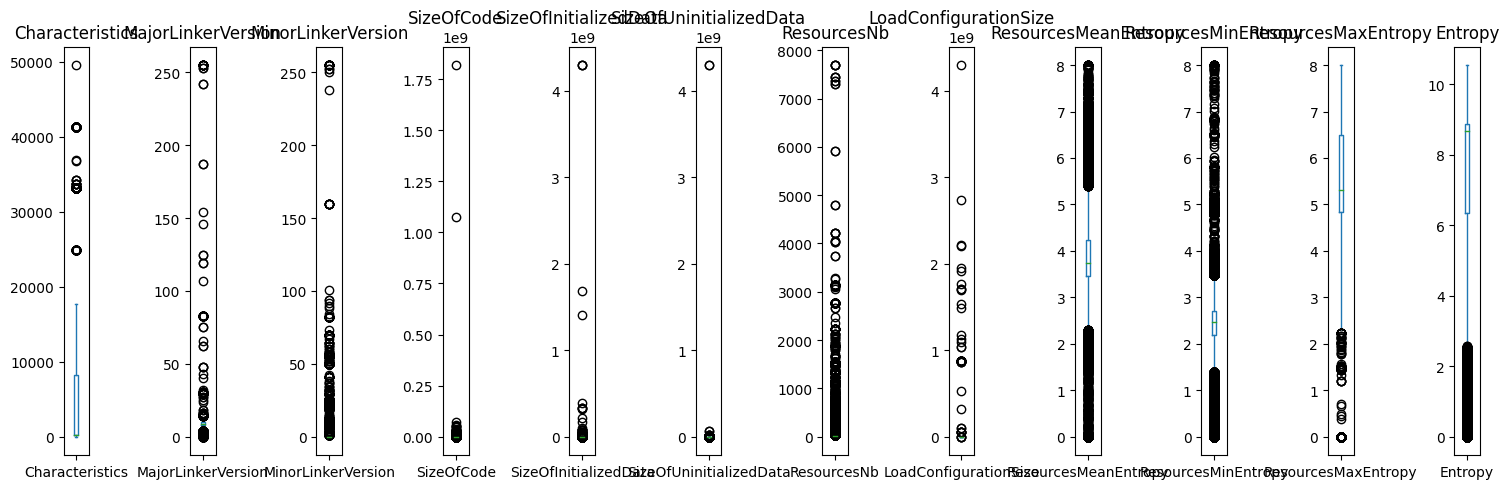

In [ ]:
# Assuming entropy_data is your DataFrame containing the data you want to plot

# Create a figure to hold the subplots
fig, axes = plt.subplots(nrows=1, ncols=len(concatenated_df.columns), figsize=(15, 5))

# Iterate over each column and create a boxplot
for i, column in enumerate(concatenated_df.columns):
    concatenated_df[column].plot(kind='box', ax=axes[i])
    axes[i].set_title(column)  # Set title for each subplot

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
concatenated_df.drop(columns=['ResourcesMeanEntropy','ResourcesMinEntropy', 'ResourcesMaxEntropy'],inplace=True)
#concatenated_df.head()

In [ ]:
x = concatenated_df.values

In [ ]:
x.shape

(138047, 9)

In [ ]:
y = pd.DataFrame(data["legitimate"])

In [ ]:
y.shape

(138047, 1)

In [ ]:
y = y.values

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(x,y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
x_train = scaler.fit_transform(x_train)

In [ ]:
scaler2 = MinMaxScaler()

In [ ]:
x_test = scaler2.fit_transform(x_test)

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # You can choose different strategies like 'median' or 'most_frequent'

# Fit the imputer on the training data and transform the data
x_train = imputer.fit_transform(x_train)

# Now, train your RandomForestClassifier using the imputed data
#rf_model = clasif.fit(x_train_imputed, y_train)


**Model building** 1 - RandamForrest

In [ ]:
# Random forrest algorithm

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clasif = RandomForestClassifier(max_depth=2,random_state=0)
rf_model = clasif.fit(x_train,y_train)

<ipython-input-36-963a073f5c8a>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = clasif.fit(x_train,y_train)


In [ ]:
from sklearn.metrics import f1_score,accuracy_score,auc,confusion_matrix

In [ ]:
# Accuracy of the train dataset
y_pred = rf_model.predict(x_train)
accuracy_score(y_train,y_pred)

0.9253148854097811

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # You can choose different strategies like 'median' or 'most_frequent'

# Fit the imputer on the training data and transform the data
x_test = imputer.fit_transform(x_test)

# Now, train your RandomForestClassifier using the imputed data
#rf_model = clasif.fit(x_train_imputed, y_train)

In [ ]:
# accuracy of the test dataset
prediction = rf_model.predict(x_test)
accuracy_score(y_test,prediction)

0.9214052879391524

In [ ]:
f1_score(y_test, prediction)

0.8592554157478273

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# build Confusion Matrix
plot_confusion_matrix = confusion_matrix(y_test, prediction)

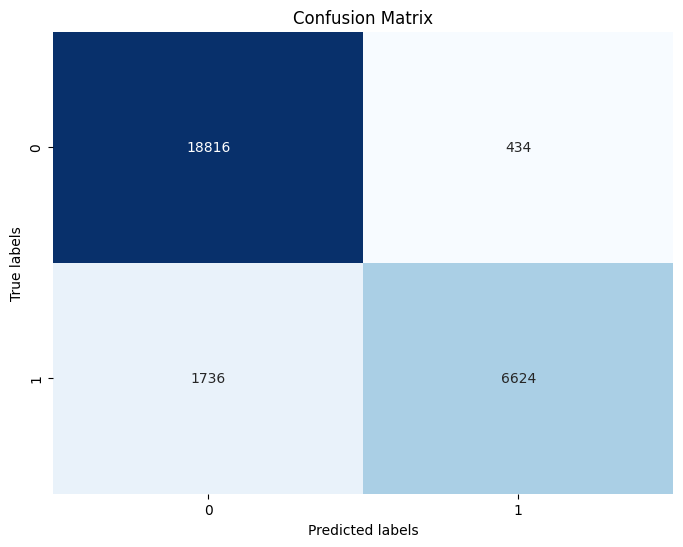

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(plot_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Neural Network building**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# define model
model = Sequential()
model.add(Dense(20,input_dim=9,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary() #print the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200       
                                                                 
 dense_1 (Dense)             (None, 8)                 168       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 377 (1.47 KB)
Trainable params: 377 (1.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile model
model.compile(loss = "binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

In [ ]:
# Fit the model
history = model.fit(x_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
3452/3452 [==============================] - 14s 4ms/step - loss: 0.2821 - accuracy: 0.8963
Epoch 2/5
3452/3452 [==============================] - 15s 4ms/step - loss: 0.1826 - accuracy: 0.9474
Epoch 3/5
3452/3452 [==============================] - 14s 4ms/step - loss: 0.1798 - accuracy: 0.9483
Epoch 4/5
3452/3452 [==============================] - 6s 2ms/step - loss: 0.1783 - accuracy: 0.9483
Epoch 5/5
3452/3452 [==============================] - 6s 2ms/step - loss: 0.1772 - accuracy: 0.9485


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
# accuracy on the training dataset
training_accuracy = model.predict(x_train)
training_accuracy =[1 if y>=0.5 else 0 for y in training_accuracy]
accuracy_score(y_train,training_accuracy)

3452/3452 [==============================] - 6s 2ms/step


0.9485136322065975

In [ ]:
# Accuracy of the test dataset
y_prediction = model.predict(x_test)
y_prediction =[1 if y>=0.5 else 0 for y in y_prediction]
# and the makbeed of the registry of the captivity of freed the comand of the programe and the captivity and the redundance reduce of the
# relatives and the corresponding capacity increasing the complexity and tune the model performance in order to the redundency check....!!!!

accuracy_score(y_test,y_prediction)

863/863 [==============================] - 1s 1ms/step


0.9516117348786671

In [ ]:
confusion_matrix(y_test,y_prediction)

array([[19021,   229],
       [ 1107,  7253]])

In [ ]:
f1_score(y_test,y_prediction)

0.9156672137356393

In [ ]:
# Extracting training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['loss']


In [ ]:
history.history.keys()
# Lakruwan yapa and the gang of the captivity related problem and the respectable ways and
# japanies and the culture based ones

dict_keys(['loss', 'accuracy'])

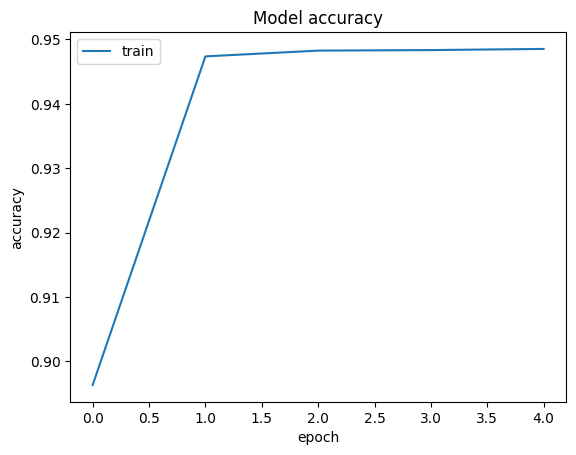

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

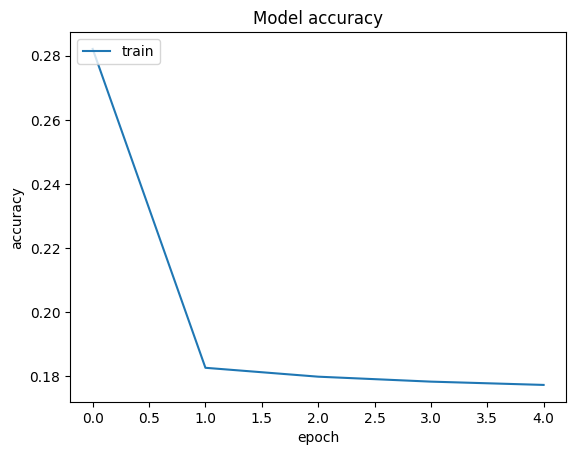

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()